In [26]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Here we import the libraries we need. We'll learn about what each does later on.

In [27]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [28]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [29]:
# We shall use resnet50 since resnet34 was not giving us good results. Perhaps more layer yields better classification....
arch=resnet50
PATH = "../data/dogbreed/"
sz=224


In [ ]:
# If the data has not yet been downloaded, uncomment and run this cell
# !kaggle competitions download -c dog-breed-identification

In [30]:
# Clean up the data directory
# Delete already existing folders
!rm -rf /home/abelleulseged/cs152/data/dogbreed/valid /home/abelleulseged/cs152/data/dogbreed/test /home/abelleulseged/cs152/data/dogbreed/train /home/abelleulseged/cs152/data/dogbreed/models

# Delete already existing files
!rm /home/abelleulseged/cs152/data/dogbreed/labels.csv /home/abelleulseged/cs152/data/dogbreed/sample_submission.csv

In [31]:
# Unzip all zip files in the dogbreed folder
!unzip -d /home/abelleulseged/cs152/data/dogbreed/ -qq /home/abelleulseged/cs152/data/dogbreed/\*.zip


4 archives were successfully processed.


View PATH

In [32]:
os.listdir(PATH)

['train',
 'sample_submission.csv',
 'labels.csv',
 'tmp',
 'labels.csv.zip',
 'test.zip',
 'train.zip',
 'sample_submission.csv.zip',
 'test']

Shuffle the dataset and take 20% as validation. Create a validation folder and move 20% of the training data into validation.The validation folder must be organized such that every validation image is in the folder corresponding to it's label. Restructure the training folder similarly. Delete the unorganized images (outside of labeled folders).

In [33]:
import pandas as pd
import numpy as np
import os, shutil

labels = pd.read_csv(f'{PATH}labels.csv')
shuffled = labels.sample(frac=1).reset_index(drop=True)                 # Shuffle
val_size = int(0.2*len(shuffled))                                       # Determine validation size
val_set = shuffled.iloc[:val_size]
val_src = val_set['id']
train_set = shuffled.iloc[val_size:].reset_index(drop=True)
train_src = train_set['id']
train_breed = train_set['breed']
train_fldr = f'{PATH}train/'
val_breed = val_set['breed']

val_fldr = f'{PATH}valid/'
if os.path.exists(val_fldr) == False:
    os.mkdir(val_fldr)                                                  # Make validation directory



for i in range(len(val_src)):
    id = val_src.iloc[i]
    if (os.path.exists(f'{val_fldr}{val_breed[i]}')) == False:
        # if the folder for this dog's breed does not yet exist in the validation directory, then create it!
        os.mkdir(f'{val_fldr}{val_breed[i]}')

    shutil.copy(f'{train_fldr}{id}.jpg',f'{val_fldr}{val_breed[i]}')
    os.remove(f'{train_fldr}{id}.jpg')                                  # Delete each validation image from the training folder after you have copied it over to the validation folder
    
for i in range(len(train_src)):
    id = train_src.iloc[i]
    if (os.path.exists(f'{train_fldr}{train_breed[i]}')) == False:
        # if the folder for this dog's breed does not yet exist in the training directory, then create it!
        os.mkdir(f'{train_fldr}{train_breed[i]}')

    shutil.copy(f'{train_fldr}{id}.jpg',f'{train_fldr}{train_breed[i]}')
    os.remove(f'{train_fldr}{id}.jpg')                                 # Delete each training image from the training folder after you have copied it over to its breed's folder inside the training folder



In [34]:
# Uncomment the below if you need to reset your precomputed activations
shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [35]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz),
                                      test_name="test")


In [36]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.03, 2)

100%|██████████| 162/162 [01:30<00:00,  1.71it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.939749   0.518731   0.837084  
    1      0.510168   0.477375   0.851272  



[array([0.47737]), 0.8512720151890047]

## Creating predictions for test data and writing CSV


Let's make predictions for that test data.  Remember that we're given log probabilities which we must 
exponentiate in order to yield true probabilities.

In [37]:
log_preds, y = learn.predict_with_targs(is_test=True) # use test dataset rather than validation dataset
probs = np.exp(log_preds)

In [38]:
df = pd.DataFrame(probs)
df.columns = data.classes

We want a new first column named *id* that has the ID extracted from each test image's filename.

In [39]:
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [40]:
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,f1705303b30da3a48db2a5f34376b947,0.000002,6.911758e-07,0.000004,0.000067,0.000065,7.757155e-07,4.025580e-07,0.000002,0.000002,...,0.000001,2.800510e-07,0.663897,0.000008,0.177867,2.717064e-07,4.925656e-08,0.000006,8.045718e-08,0.000004
1,a9b79809bc1301f8d148e15bfecf6485,0.000103,2.010291e-05,0.000166,0.000005,0.000228,3.540699e-04,2.678135e-04,0.000270,0.000014,...,0.000167,1.904207e-04,0.000048,0.000034,0.000009,5.991722e-05,6.946448e-03,0.000099,3.108542e-05,0.000029
2,cc94a3bb7191a247f59e1540d8430c93,0.000030,4.744229e-05,0.000097,0.000188,0.000432,8.663788e-02,1.249723e-04,0.000391,0.000083,...,0.000116,3.537598e-05,0.000035,0.000369,0.000008,7.853878e-04,3.707109e-05,0.000034,8.964462e-05,0.000064
3,f7b489a38302afc010d8a386a1b7d085,0.000033,1.560929e-04,0.000065,0.000099,0.000753,1.550122e-01,9.709308e-05,0.003205,0.000211,...,0.000127,8.641313e-05,0.000084,0.000429,0.000007,1.430746e-03,4.939229e-05,0.000106,1.164856e-04,0.000073
4,6e21c96226078576342ca66e25eb1aa9,0.003681,4.628481e-05,0.000178,0.001450,0.000025,2.103566e-04,3.455696e-05,0.000008,0.000003,...,0.000018,8.587474e-06,0.000368,0.000073,0.000334,1.375404e-05,4.146262e-05,0.000294,1.962867e-04,0.000122


## Choosing a learning rate

The *learning rate* determines how quickly or how slowly you want to update the *weights* (or *parameters*). Learning rate is one of the most difficult parameters to set, because it significantly affects model performance.

The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

We first create a new learner, since we want to know how to set the learning rate for a new (untrained) model.

In [41]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [42]:
lrf=learn.lr_find()
print(lrf)

 94%|█████████▍| 120/128 [00:02<00:00, 60.79it/s, loss=8.74]
None


Our `learn` object contains an attribute `sched` that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

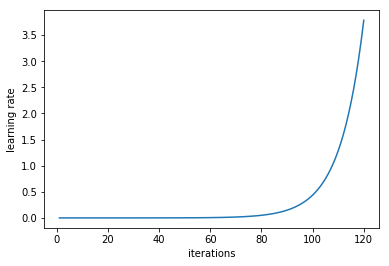

In [43]:
learn.sched.plot_lr()


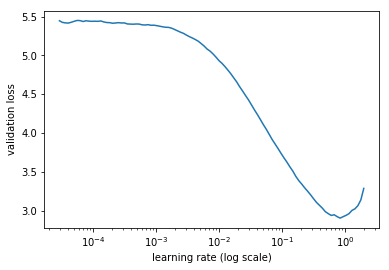

In [44]:
learn.sched.plot()


Based on the above plot, we can pick an optimal learning rate i.e. still increasing but low validation loss.

## Improving our model

### Data augmentation

In [45]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [46]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [47]:
ims = np.stack([get_augs() for i in range(6)])

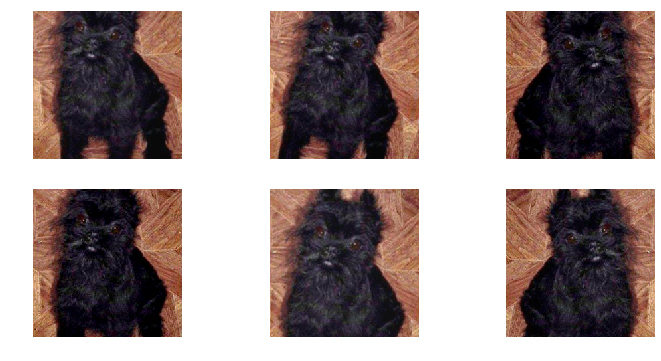

In [48]:
plots(ims, rows=2)

Let's create a new `data` object that includes this augmentation in the transforms.

Since we're using data augmentation, we can't use the speedup of precomputing the activations of the network up to, but not including, the final layer for each image.  Instead, we must feed each (augmented) image to the network. Thus, we don't provide a ```precompute``` parameter to the ```pretrained``` method.

In [49]:
data = ImageClassifierData.from_paths(PATH, test_name="test", tfms=tfms)
learn = ConvLearner.pretrained(arch, data)

By default when we create a learner, it sets all but the last layer to *frozen*. That means that it's still only updating the weights in the last layer when we call `fit`.

In [50]:
learn.fit(0.01, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      1.742422   1.029284   0.809687  
    1      0.987348   0.644025   0.860568  



[array([0.64403]), 0.860567514093888]

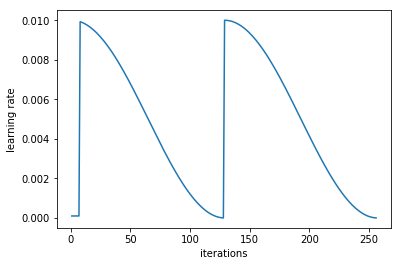

In [51]:
learn.sched.plot_lr()

In [52]:
learn.save('dogsbreed_lastlayer')

In [53]:
learn.load('dogsbreed_lastlayer')

In [54]:
log_preds, y = learn.predict_with_targs() # use test dataset rather than validation dataset
probs = np.exp(log_preds)
accuracy_np(probs, y)

0.8605675146771037

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). To use TTA on the validation set, we can use the learner's `TTA()` method, and then take the average prediction from these images. 

In [55]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y)

0.8649706457925636

This gives a slight enhancement to the accuracy. We can save this model for later use:

In [56]:
learn.save('dogbreed_augmentation')
learn.load('dogbreed_augmentation')

Let's try another Kaggle submission using our model so far (and using test-time augmentation).

In [57]:
log_preds,y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds), 0)
df = pd.DataFrame(probs)
df.columns = data.classes
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])
SUBM = f'../data/output/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}dogbreedop.gz', compression='gzip', index=False)

We write into the *output* directory the dogbreedop.gz CSV file. 

![152](https://user-images.githubusercontent.com/35898484/45982682-8cda6c00-c00e-11e8-8969-e124324199d9.PNG)
